# Gaussian Process for contouring

This week we are going to use a gaussian process for interpolating between sample points. All we need is `geopandas`, `numpy`, `matplotlib`, `itertools`, `contextily`, and a few modules from `sklearn`

First we will import our packages

In [1]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
import contextily as ctx

%matplotlib inline

Then we will read in the same dataset we used in the Green's functions notebook.

In [2]:
data = gpd.read_file("geochemistry_subset.shp")
data.drop(
    index=[3, 16], inplace=True
) 

Now let's make the start of a grid from the x and y coordinates (min and max)

In [3]:
x_values = np.linspace(min(data.geometry.x), max(data.geometry.x), num=50)
y_values = np.linspace(min(data.geometry.y), max(data.geometry.y), num=50)

More work on creating our sample grid that we will interpolate to

In [4]:
xy = np.array(list(product(x_values, y_values)))

Next let's make a list with all the sample points and their x-y values

In [5]:
points = list(zip(data.geometry.x, data.geometry.y))

And while we are at it, let's make a `pandas` `Series` with the values we want to interpolate between points

In [6]:
values = data.qvalue

We have built our grid and now we want to use the `GaussianProcessRegressor` from `sklearn` with an `RBF` kernel to interpolate our data. A good background on Gaussian processes can be found [here](https://en.wikipedia.org/wiki/Gaussian_process) and [here](http://www.gaussianprocess.org/) and I love [this one](http://katbailey.github.io/post/gaussian-processes-for-dummies/). It took me quite a bit of reading to figure out what kernel I wanted to use and decided that `RBF` seemed easy enough to implement with `sklearn`. Let's go ahead and import the methods we need to fit the model

In [7]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

We will set our `RBF` kernel and choose some length scales, this took me some trial and error to figure out what was appropriate for the dataset

In [8]:
kernel = RBF(length_scale=1e2, length_scale_bounds=(3e4, 1e6))

Then we fit the `GaussianProcessRegressor` to the points and the values

In [9]:
gp = GaussianProcessRegressor(kernel=kernel)
gp.fit(points, values)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=RBF(length_scale=100), n_restarts_optimizer=0,
             normalize_y=False, optimizer='fmin_l_bfgs_b',
             random_state=None)

Now we want to predict the values at all the points on our grid. To do this we use `gp.predict` and feed in our grid, and we also want the mean squared error which is `MSE`

In [10]:
y_pred, MSE = gp.predict(xy, return_std=True)

Then we have to do some grid reshaping and prediction reshaping gymnastics to get things back into our spatial layout

In [11]:
X0, X1 = xy[:, 0].reshape(50, 50), xy[:, 1].reshape(50, 50)
predictions = np.reshape(y_pred, (50, 50))
error = np.reshape(MSE, (50, 50))

Then, just like last week we want to add a nice basemap using `contextily`

In [12]:
# this cell creates a function that grabs the stamen terrain tiles
def add_basemap(
    ax, zoom, url="http://tile.stamen.com/terrain/tileZ/tileX/tileY.png"
):
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(
        xmin, ymin, xmax, ymax, zoom=zoom, url=url
    )
    ax.imshow(basemap, extent=extent, interpolation="bilinear")
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))

We have predictions, a basemap, and our sample points, let's go ahead and plot it all up and see what we have

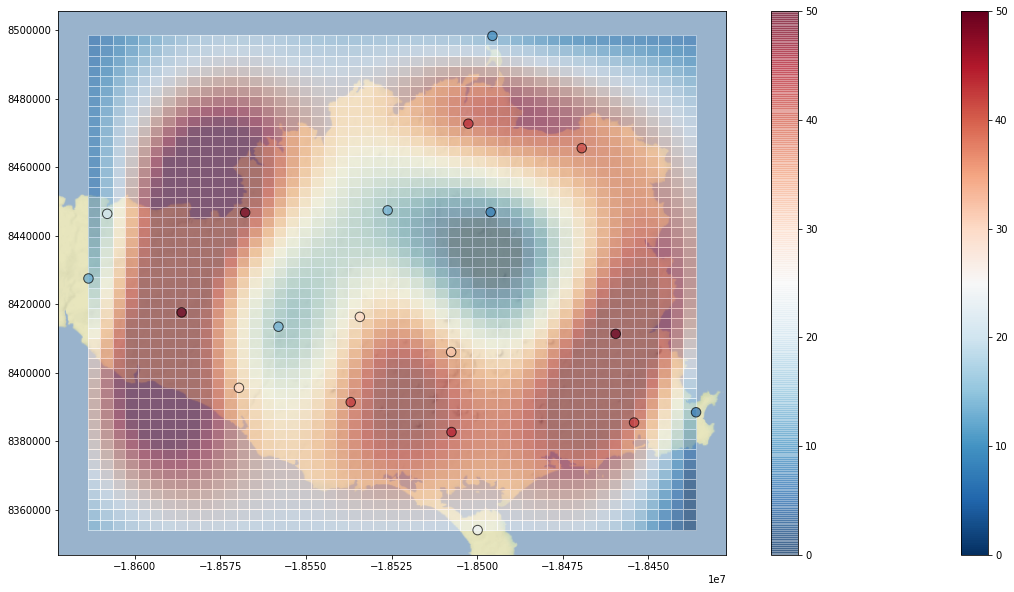

In [13]:
ax = data.plot(
    column="qvalue",
    vmin=0,
    vmax=50,
    figsize=(20, 10),
    legend=True,
    cmap="RdBu_r",
    alpha=0.7,
    edgecolor="k",
    markersize=90,
    zorder=2,
)
add_basemap(ax, zoom=9)  # add our basemap to the plot
im = ax.pcolormesh(
    X0,
    X1,
    predictions,
    cmap="RdBu_r",
    alpha=0.5,
    vmin=0,
    vmax=50,
    edgecolor=(1.0, 1.0, 1.0, 1.0),
    linewidth=0.01,
    zorder=1,
)
plt.colorbar(im, ax=ax)

Since we have the `MSE` for the grid we can also plot that up as well and see how well things fit the spatial data

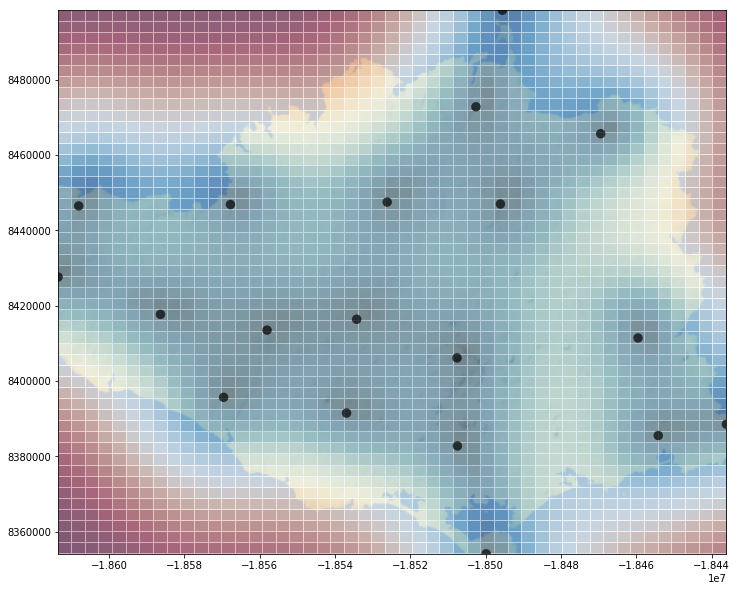

In [14]:
ax = data.plot(
    vmin=0,
    vmax=50,
    figsize=(20, 10),
    legend=True,
    c="black",
    alpha=0.7,
    edgecolor="none",
    markersize=90,
    zorder=2,
)
ax.pcolormesh(
    X0,
    X1,
    error,
    cmap="RdBu_r",
    alpha=0.5,
    edgecolor=(1.0, 1.0, 1.0, 1.0),
    linewidth=0.01,
    zorder=1,
)
add_basemap(ax, zoom=9)  # add our basemap to the plot

This notebook is licensed as CC-BY, use and share to your hearts content.